In [1]:
from pathlib import Path

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [4]:
path = Path("dataset_segmentation_small/")
path_lbl = path / "labels"
path_img = path / "images"

In [5]:
get_labels = lambda x: path_lbl / x.name
codes = np.array(['background','fruit'], dtype='str'); codes       

array(['background', 'fruit'], dtype='<U10')

In [6]:
fnames = get_image_files(path_img/ "train")
mnames = get_image_files(path_lbl)

In [7]:
m = open_mask(mnames[0])

Custom class needed to open masks with values of `[0, 255]` insted of `[0,1]`

In [8]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

codes = ['background','fruit']

In [9]:
#size for cropped masks, need to change size for big masks (we can use transfer learning)
size = 256
bs=8

custom accuracy function, maybe something is wrong @Simone

In [16]:
def seg_accuracy(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [17]:
src = (SegItemListCustom.from_folder(path_img)
       .split_by_folder()
       .label_from_func(get_labels, classes=codes))

In [18]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [19]:
data.classes

['background', 'fruit']

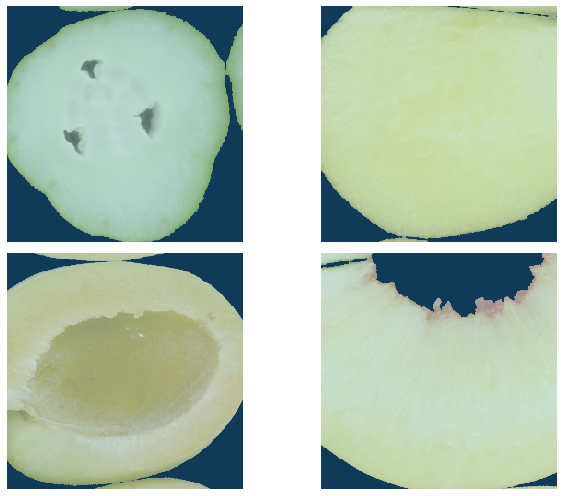

In [20]:
data.show_batch(2, figsize=(10,7))

In [21]:
learn = unet_learner(data, models.resnet34, metrics=seg_accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


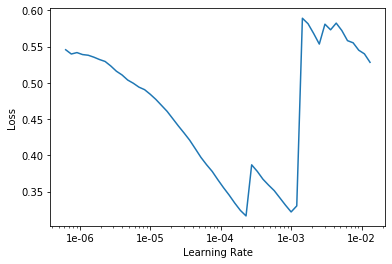

In [22]:
lr_find(learn)
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(10, 5e-5)

epoch,train_loss,valid_loss,seg_accuracy,time
0,0.065944,0.026264,0.990987,04:02
1,0.015176,0.010733,0.996442,03:59
2,0.011112,0.007384,0.997419,03:59
3,0.011570,0.009239,0.997225,03:59
4,0.005972,0.011493,0.995333,03:59
5,0.004387,0.004240,0.998269,03:59
6,0.003811,0.003981,0.998357,03:59
7,0.003719,0.004315,0.998308,03:59
8,0.003532,0.004129,0.998358,03:59
9,0.003772,0.003878,0.998412,03:59


In [24]:
learn.export()

In [16]:
#learn.save('stage-1-256-small_images-3-epoch')
learn = learn.load("test1-10epoch-256")

test mask save, need to write function to compare actual mask and predicted mask

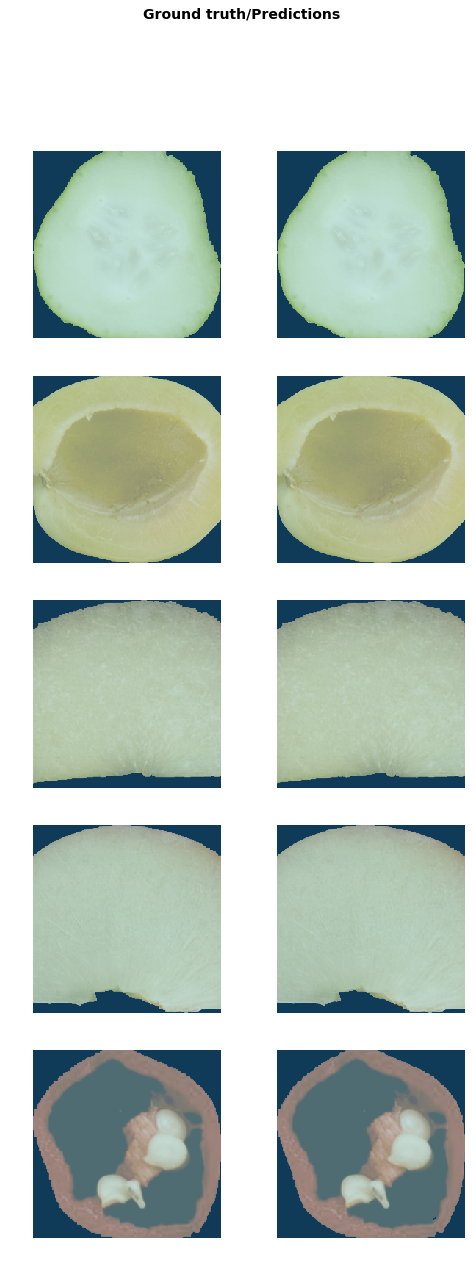

In [17]:
learn.show_results()

## Benchmark model accuracy on Test dataset

In [6]:
inf_size = 512

In [14]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [11]:
inf_data =  (SegItemListCustom.from_folder(path_img)
            .split_by_folder(train='train', valid='valid')
            .label_from_func(get_labels, classes=codes)
            .transform(size=inf_size, tfm_y=True, resize_method=ResizeMethod.PAD, padding_mode = 'zeros')
            .databunch(bs=bs)
            .normalize(imagenet_stats))

In [15]:
def seg_accuracy(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [16]:
inf_learn = unet_learner(inf_data, models.resnet34, metrics=[seg_accuracy]).load("test1-10epoch-256")

In [17]:
def seg_test_image(img, real_mask):
    pred_mask, _, _ = inf_learn.predict(open_image(img))
    real_mask = open_mask(real_mask, div=True).apply_tfms([],size=inf_size, resize_method=ResizeMethod.PAD, padding_mode = 'zeros')
    wrong = np.count_nonzero(pred_mask.data != real_mask.data)
    
    intersection = np.logical_and(real_mask.data, pred_mask.data)
    union = np.logical_or(real_mask.data, pred_mask.data)
    iou_score = torch.div(torch.sum(intersection),torch.sum(union).float())
    
    return iou_score, wrong

In [18]:
#warning works only with square inf_size
def seg_bench_test():
    imgs = get_image_files(path_img / "final_test")
    masks = [get_labels(f) for f in imgs]
    wrongs = torch.empty(len(imgs), dtype=torch.float32)
    iou_scores = torch.empty(len(imgs), dtype=torch.float32)
    for i, img, mask in zip(range(len(imgs)), imgs, masks):
        iou_score, wrong = seg_test_image(img, mask)
        wrongs[i] = wrong
        iou_scores[i] = iou_score
                            
    wrong_perc = torch.mean(wrongs) * 100 / inf_size**2
    print(f"perc of wrong pixels: {wrong_perc}%")
    print(f"mean accuracy: {100-wrong_perc}%")
    print(f"max wrong per image: {torch.max(wrongs)} over {inf_size**2} pixels")
    print(f"mean IoU: {torch.mean(iou_scores)}")
    print(f"min IoU: {torch.min(iou_scores)}")

In [19]:
seg_bench_test()

perc of wrong pixels: 0.15303963422775269%
mean accuracy: 99.84696197509766%
max wrong per image: 4211.0 over 262144 pixels
mean IoU: 0.9977615475654602
min IoU: 0.97233647108078


In [21]:
def plot_pixel_difference(img_path, real_mask_path, figsize=(20,20)):
    img = open_image(img_path)
    pred_mask, _, _ = inf_learn.predict(img)
    real_mask = open_mask(real_mask_path, div=True).apply_tfms([],size=inf_size, resize_method=ResizeMethod.PAD, padding_mode = 'zeros')
    real_mask = image2np(real_mask.data)
    pred_mask = image2np(pred_mask.data)

    img = img.apply_tfms([],size=inf_size, resize_method=ResizeMethod.PAD, padding_mode = 'zeros')
    img = image2np(img.data)
    diff = pred_mask != real_mask
    img[diff==1] = (0, 0 ,1) # 0000FF is blue
    fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(img)

bisogna passare come parametri l'immagine e la vera maschera, fnames è solo una lista con tutte le immagini per il training usata per il test

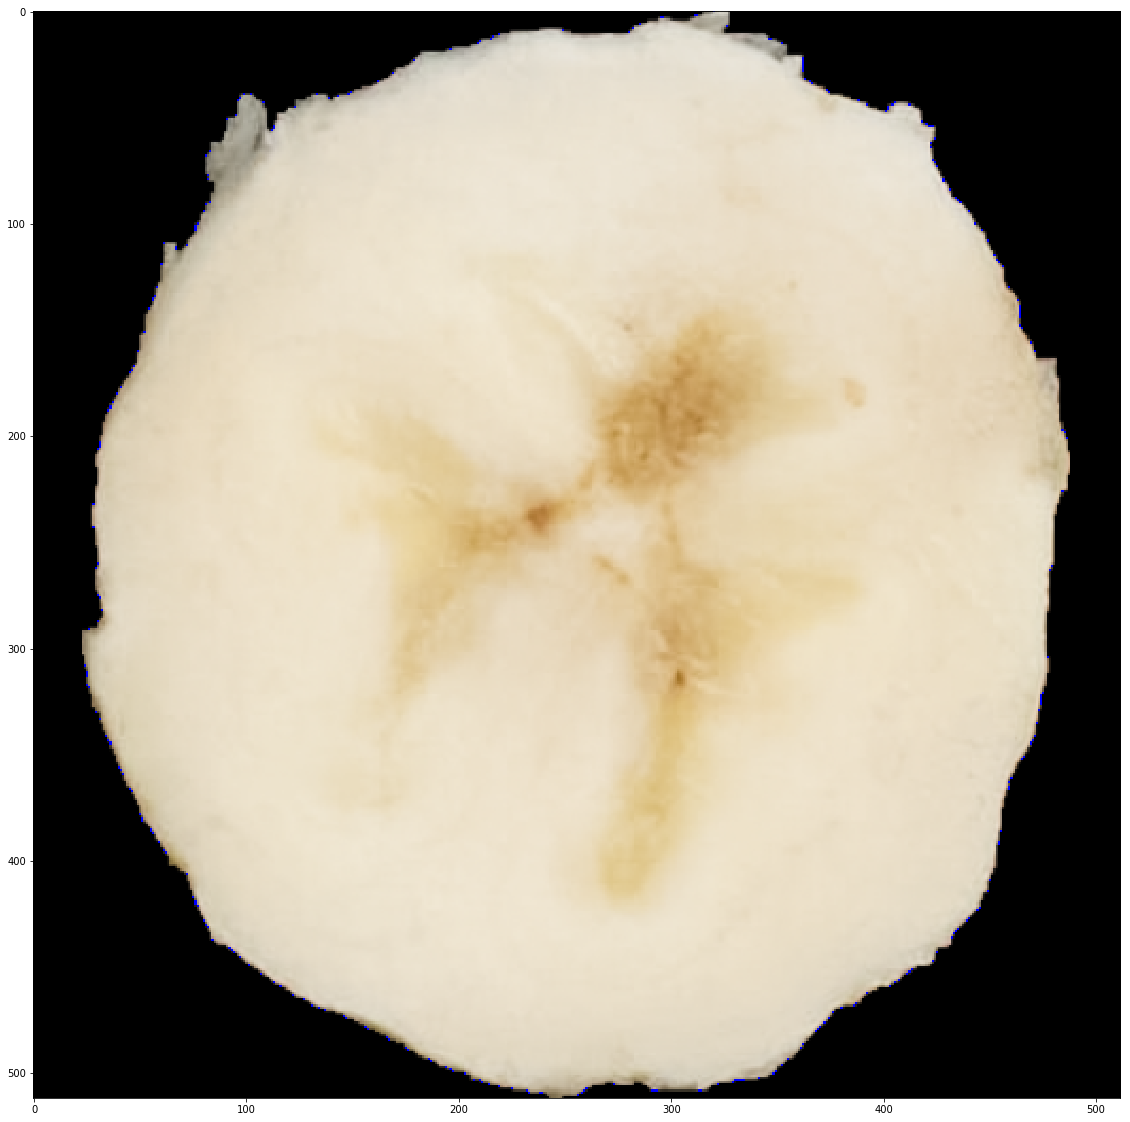

In [25]:
img = 10
plot_pixel_difference(fnames[img], get_labels(fnames[img]))